# Transformer model for Trajectory Prediction

Benjamin Mo

2021 Master's Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import tensorflow as tf
import numpy as np


## Load data

Data was compiled from the TrajNet++ dataset. No preprocessing has yet to be performed. There are 240890 sequences in the training data. Each sequence has a total of 20 $(x, y)$ positions. The first 8 positions will be given as input, and the last 12 positions are the ground truth labels. Split up the training data into training data and validation data.

Each sequence is a $20 \times 3$ matrix. The first column is the time of the frame, the second and third columns are the $(x, y)$ positions at that time, respectively. The time is centered at the $8^{th}$ frame.

Split the data up into encoder input sequence $(8 \times 1)$, decoder input sequence (shift right) $(12 \times 1)$, and true output sequence $(12 \times 1)$

In [ ]:
def normalize(data):
    data_mean = np.mean(data, axis=(0,1))
    data_std = np.std(data, axis=(0,1))
    
    normalized_data = (data - data_mean) / data_std
    return normalized_data, data_mean, data_std

In [150]:

data = np.load('train_data.npy')
# val_dataset = np.load('val_data.npy')

# data = np.concatenate((train_dataset, val_dataset), axis=0)
print(data.shape)

N = data.shape[0]
idx = np.random.permutation(N)

data = data[idx]

val_data = data[200000::]
train_data = data[0:200000]
print(train_data.shape)
print(val_data.shape)

np.save('train_data.npy', train_data)
np.save('val_data.npy', val_data)

(240890, 20, 3)
(200000, 20, 3)
(40890, 20, 3)


In [151]:
def load_data(filepath):
    # Load data from file
    data = np.load(filepath)
    normalized_data, data_mean, data_std = normalize(data[:, :, 1::])

    # Compute the positional increments at each step
    seq_incr = np.zeros_like(data[:, :, 1::])
    seq_incr[:, 1::, :] = data[:, 1::, 1::] - data[:, 0:-1, 1::]

    # Concatenate to data array
    data = np.concatenate((data, seq_incr), axis=-1)

    # Split data array into input and output sequences
    in_seq = tf.cast(data[:, 0:8, :], dtype=tf.float32)
    tar_seq = tf.cast(data[:, 7:-1, :], dtype=tf.float32)
    gnd_true = tf.cast(data[:, 8::, :], dtype=tf.float32)

    norm_in_seq = tf.cast(normalized_data[:, 0:8, :], dtype=tf.float32)
    norm_tar_seq = tf.cast(normalized_data[:, 7:-1, :], dtype=tf.float32)
    norm_gnd_true = tf.cast(normalized_data[:, 8::, :], dtype=tf.float32)    

    # Compile all of the necessary information into a dataset
    dataset = {'in_seq': in_seq[:, :, 1:3], 
            'in_seq_times': in_seq[:, :, 0],
            'tar_seq': tar_seq[:, :, 1:3],
            'gnd_true': gnd_true[:, :, 1:3],
            'start_point': in_seq[:, -1, 1:3],
            'in_seq_incr': in_seq[:, :, 3::],
            'tar_seq_incr': tar_seq[:, :, 3::],
            'gnd_true_incr': gnd_true[:, :, 3::],
            'batched': False,
            'norm_in_seq': norm_in_seq,
            'norm_tar_seq': norm_tar_seq,
            'norm_gnd_true': norm_gnd_true,
            'mean': data_mean, 
            'std': data_std
            }
    
    return dataset

train_dataset = load_data('train_data.npy')
val_dataset = load_data('val_data.npy')

# Adjust validation data norms
val_dataset['norm_in_seq'] = val_dataset['std']*val_dataset['norm_in_seq'] + val_dataset['mean']
val_dataset['norm_tar_seq'] = val_dataset['std']*val_dataset['norm_tar_seq'] + val_dataset['mean']
val_dataset['norm_gnd_true'] = val_dataset['std']*val_dataset['norm_gnd_true'] + val_dataset['mean']

val_dataset['norm_in_seq'] = (val_dataset['in_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_tar_seq'] = (val_dataset['tar_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_gnd_true'] = (val_dataset['gnd_true'] - train_dataset['mean']) / train_dataset['std']

for key in train_dataset.keys():
    if key != 'batched':
        print("'{}' dimension: {}".format(key, train_dataset[key].shape))

'in_seq' dimension: (200000, 8, 2)
'in_seq_times' dimension: (200000, 8)
'tar_seq' dimension: (200000, 12, 2)
'gnd_true' dimension: (200000, 12, 2)
'start_point' dimension: (200000, 2)
'in_seq_incr' dimension: (200000, 8, 2)
'tar_seq_incr' dimension: (200000, 12, 2)
'gnd_true_incr' dimension: (200000, 12, 2)
'norm_in_seq' dimension: (200000, 8, 2)
'norm_tar_seq' dimension: (200000, 12, 2)
'norm_gnd_true' dimension: (200000, 12, 2)
'mean' dimension: (2,)
'std' dimension: (2,)


## Linear Embedding

Linear embedding is implemented using a single fully connected layer to project the $(x,y)$ position at each frame into a $d_{model}$ length vector. The default value for $d_{model}=512$

$(x, y) \in \mathbb{R}^{2\times 1} :\longrightarrow \mathbb{R}^{512\times 1} $

In [ ]:
# Linear Embedding layer for the transformer. Maps input sequences into d_model 
# length vectors and scales by the square-root of d_model. Default d_model = 512
class LinearEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model=512, name="embedding"):
        super(LinearEmbedding, self).__init__(name=name)

        self.d_model = d_model
        self.embedding = tf.keras.layers.Dense(d_model)
    
    def call(self, inputs):
        
        outputs = self.embedding(inputs)
        outputs *= tf.math.sqrt( tf.cast(self.d_model, tf.float32) )

        return outputs

In [ ]:
# Test output of Linear Embedding layer
print("Linear Embedding Layer (Encoder side):")
LE_enc = LinearEmbedding(d_model=512)
inputs = train_dataset['in_seq'][0:1]
LE_enc_out = LE_enc(inputs)

print("Input shape: {}".format(inputs.shape))
print("Output shape: {}".format(LE_enc_out.shape))

print("===============================")

print("Linear Embedding Layer (Decoder side):")
LE_dec = LinearEmbedding(d_model=512)
inputs = train_dataset['tar_seq'][0:1]
LE_dec_out = LE_dec(inputs)

print("Input shape: {}".format(inputs.shape))
print("Output shape: {}".format(LE_dec_out.shape))

Linear Embedding Layer (Encoder side):
Input shape: (1, 8, 2)
Output shape: (1, 8, 512)
Linear Embedding Layer (Decoder side):
Input shape: (1, 12, 2)
Output shape: (1, 12, 512)


## Positional Encoding

Positional encoding in order to capture the positions of each input relative to each other, since the linear embedding does not capture that information

Use the equation...

*Equation goes here*

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model=512):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.indices = tf.range(d_model, dtype=tf.float32)[tf.newaxis,:]

        self.angles = 1 / tf.pow(10000, (self.indices / tf.cast(d_model, tf.float32)))


    def positional_encoding(self, position):
        angle_rads = position * self.angles
        
        pos_encoding = np.zeros_like(angle_rads)
        # sin every even index of position
        pos_encoding[..., 0::2] = tf.math.sin(angle_rads[..., 0::2])
        # cos every odd index of position
        pos_encoding[..., 1::2] = tf.math.cos(angle_rads[..., 1::2])

        return tf.cast(pos_encoding, dtype=tf.float32)


    def call(self, inputs):
        position = inputs[..., tf.newaxis]
        return self.positional_encoding(position)

In [ ]:
# Some code testing the output of calling positional encoding ...
print("Positional Encoding with Times (Encoder side)")
PE_enc = PositionalEncoding(d_model=512)
inputs = train_dataset['in_seq_times'][0:1]
PE_enc_out = PE_enc(inputs)

print("Input shape: {}".format(inputs.shape))
print("Output shape: {}".format(PE_enc_out.shape))

print("===============================")

print("Positional Encoding with Position (Decoder side)")
PE_dec = PositionalEncoding(d_model=512)
seq_len = train_dataset['tar_seq_incr'][0:1].shape[1]
inputs = tf.range(seq_len, dtype=tf.float32)
PE_dec_out = PE_dec(inputs)

print("Input shape: {}".format(inputs.shape))
print("Output shape: {}".format(PE_dec_out.shape))



Positional Encoding with Times (Encoder side)
Input shape: (1, 8)
Output shape: (1, 8, 512)
Positional Encoding with Position (Decoder side)
Input shape: (12,)
Output shape: (12, 512)


In [ ]:
# Add the output from the Linear Embedding with the Positional Encoding
print("Encoder Input")
encoder_in = LE_enc_out + PE_enc_out

print("Linear Embedding Output: {}".format(LE_enc_out.shape))
print("Positional Encoding Output: {}".format(PE_enc_out.shape))
print("Encoder input dimension: {}".format(encoder_in.shape))

print("===============================")

print("Decoder Input")
decoder_in = LE_dec_out + PE_dec_out

print("Linear Embedding Output: {}".format(LE_dec_out.shape))
print("Positional Encoding Output: {}".format(PE_dec_out.shape))
print("Decoder input dimension: {}".format(decoder_in.shape))

Encoder Input
Linear Embedding Output: (1, 8, 512)
Positional Encoding Output: (1, 8, 512)
Encoder input dimension: (1, 8, 512)
Decoder Input
Linear Embedding Output: (1, 12, 512)
Positional Encoding Output: (12, 512)
Decoder input dimension: (1, 12, 512)


## Multi-Head Attention

In [ ]:
# Scaled dot product attention function
def scaled_dot_prodct_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast( tf.shape(key)[-1], tf.float32 )
    logits = matmul_qk / tf.math.sqrt(depth)

    # Add mask if necessary
    if mask is not None:
        logits += (mask * -1e9)  # Make masked values a very large negative value
    
    attention_weights = tf.nn.softmax(logits, axis=1)

    return tf.matmul(attention_weights, value)

# Implement multi-head attention using Model subclassing
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model=512, num_heads=8, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # Dimension of queries, keys and values
        self.depth = d_model // self.num_heads 

        # Dense layers for computing linear projections of queries, keys and values
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # Dense layer for final linear projection of concatenated scaled dot-product attention outputs
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])


    def call(self, inputs):
        # inputs for query, key, value, and mask are stored as a dictionary because call only takes one input object
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']

        batch_size = tf.shape(query)[0]

        # Linear projections to depth dimension
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split heads - total weight dimensions for each dense layer is (d_model x d_model), its just each head weight concatenated together
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Compute scaled dot-product attention
        scaled_attention = scaled_dot_prodct_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Concatenate the outputs
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model))

        # Run concatenated outputs through dense layer
        outputs = self.dense(concat_attention)

        return outputs

In [ ]:
# Test Multi Head Attention
print("Multi Head Attention")
input = {
    'query': encoder_in,
    'key': encoder_in,
    'value': encoder_in,
    'mask': None
}
for key in input.keys():
  if input[key] != None:
    print("{:s} dimension: {}".format(key, input[key].shape))
  else:
    print("{:s} dimension: None".format(key))

MHA = MultiHeadAttention(d_model=512, num_heads=8)
MHA_out = MHA(input)

print("\nOutput dimension: {}".format(MHA_out.shape))

Multi Head Attention
query dimension: (1, 8, 512)
key dimension: (1, 8, 512)
value dimension: (1, 8, 512)
mask dimension: None

Output dimension: (1, 8, 512)


## Masking

In [ ]:
target_seq_len = 12
look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((target_seq_len, target_seq_len)), -1, 0)
print("Look ahead mask")
print(look_ahead_mask.numpy())

Look ahead mask
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Encoder

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=512, d_ff=1024, num_heads=8, dropout=0.8, 
                                                        name="encoder_layer"):
        super(EncoderLayer, self).__init__(name=name)

        # Multi-head attention block
        self.attention = MultiHeadAttention(d_model=d_model, 
                                            num_heads=num_heads, 
                                            name="encoder_attention")

        # Feed forward nework
        self.feedforward = tf.keras.Sequential([
            tf.keras.layers.Dense(d_ff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        # Dropout and Normalization Layers
        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout2 = tf.keras.layers.Dropout(rate=dropout)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Attention + normalization sublayer
        attention_out = self.attention({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': None
        })
        attention_out = self.dropout1(attention_out)
        attention_out = self.layernorm1(attention_out + inputs)

        # Feedforward + normalization sublayer
        outputs = self.feedforward(attention_out)
        outputs = self.dropout2(outputs)
        outputs = self.layernorm2(outputs + attention_out)

        return outputs


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=1024, dropout=0.8, name="encoder"):
        super(Encoder, self).__init__(name=name)

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding and positional encoding layers
        self.embedding = LinearEmbedding(d_model=d_model, name="input_embedding")
        self.pos_encoding = PositionalEncoding(d_model=d_model)

        self.encoding_layers = [EncoderLayer(
                                    d_model=d_model, 
                                    d_ff=d_ff, 
                                    num_heads=num_heads, 
                                    dropout=dropout, 
                                    name="encoder_layer_{}".format(i)) 
                                for i in range(num_layers)]
                                
        self.dropout = tf.keras.layers.Dropout(rate=dropout)

    def call(self, inputs):    
        # inputs -->  N x seq_len x 3
        # times = inputs['in_seq_times']
        # seq = inputs['in_seq']
        [seq, times] = inputs
    
        # Input embedding and positional encoding
        embedded_inputs = self.embedding(seq)
        embedded_inputs += self.pos_encoding(times)

        outputs = self.dropout(embedded_inputs)

        # Encoding layers
        for i in range(self.num_layers):
            outputs = self.encoding_layers[i](outputs)

        return outputs

In [ ]:
# Test encoder
input = [train_dataset['in_seq_incr'][0:1], train_dataset['in_seq_times'][0:1]]
print("Encoder input sequence dimension: {}".format(input[0].shape))
print("Encoder input times dimension: {}".format(input[1].shape))

enc = Encoder(num_layers=6, d_model=512, num_heads=8, d_ff=1024, dropout=0.8)
enc_output = enc(input)

print("Encoder output dimension: {}".format(enc_output.shape))

Encoder input sequence dimension: (1, 8, 2)
Encoder input times dimension: (1, 8)
Encoder output dimension: (1, 8, 512)


## Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=512, d_ff=1024, num_heads=8, dropout=0.8, name="decoder_layer"):
        super(DecoderLayer, self).__init__(name=name)

        self.attention1 = MultiHeadAttention(d_model=d_model, 
                                            num_heads=num_heads, 
                                            name="decoder_attention_1")

        self.attention2 = MultiHeadAttention(d_model=d_model, 
                                            num_heads=num_heads, 
                                            name="decoder_attention_2")

        self.feedforward = tf.keras.Sequential([
            tf.keras.layers.Dense(d_ff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.dropout1 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout2 = tf.keras.layers.Dropout(rate=dropout)
        self.dropout3 = tf.keras.layers.Dropout(rate=dropout)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    
    def call(self, inputs):
        [inputs, encoder_outputs, look_ahead_mask] = inputs

        # First multi-head attention sublayer
        # Use look-ahead mask
        attention1_out = self.attention1({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })
        attention1_out = self.dropout1(attention1_out)
        attention1_out = self.layernorm1(attention1_out + inputs)

        # Second multi head attention sublayer
        # Use padding mask, key and value are from encoder output
        attention2_out = self.attention2({
            'query': attention1_out,
            'key': encoder_outputs,
            'value': encoder_outputs,
            'mask': None
        })
        attention2_out = self.dropout2(attention2_out)
        attention2_out = self.layernorm2(attention2_out + attention1_out)
        
        # Feedforward sublayer
        outputs = self.feedforward(attention2_out)
        outputs = self.dropout3(outputs)
        outputs = self.layernorm3(outputs + attention2_out)

        return outputs

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=1024, dropout=0.8, name="decoder"):
        super(Decoder, self).__init__(name=name)

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = LinearEmbedding(d_model, name="output_embedding")
        self.pos_encoding = PositionalEncoding(d_model)

        self.decoding_layers = [DecoderLayer(
                                    d_model=d_model, 
                                    d_ff=d_ff, 
                                    num_heads=num_heads, 
                                    dropout=dropout, 
                                    name="decoder_layer_{}".format(i)) 
                                for i in  range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate=dropout)
    
    def call(self, inputs):
        [decoder_inputs, encoder_outputs, look_ahead_mask] = inputs
        seq_len = decoder_inputs.shape[1]

        # Output embedding and positional encoding
        embedded_inputs = self.embedding(decoder_inputs)
        embedded_inputs += self.pos_encoding(tf.range(seq_len, dtype=tf.float32))

        outputs = self.dropout(embedded_inputs)

        # Decoding layers
        for i in range(self.num_layers):
            outputs = self.decoding_layers[i]([outputs, encoder_outputs, look_ahead_mask])

        return outputs

In [ ]:
print("Decoder")
input = [train_dataset['tar_seq_incr'][0:1], enc_output, look_ahead_mask]
print("Target Sequence dimension: {}".format(input[0].shape))
print("Encoder Output dimension: {}".format(input[1].shape))
print("Look Ahead Mask dimension: {}".format(input[2].shape))

dec = Decoder(num_layers=6, d_model=512, num_heads=8, d_ff=1024, dropout=0.8)
dec_out = dec(input)
print("Decoder Output dimension: {}".format(dec_out.shape))

Decoder
Target Sequence dimension: (1, 12, 2)
Encoder Output dimension: (1, 8, 512)
Look Ahead Mask dimension: (12, 12)
Decoder Output dimension: (1, 12, 512)


## Final Linear Layer

In [ ]:
# Just one dense layer, take the last output position as predicted next step

class OutputLinear(tf.keras.layers.Layer):
  def __init__(self, out_dim=2, name='output_linear_layer'):
    super(OutputLinear, self).__init__(name=name)

    self.linear = tf.keras.layers.Dense(out_dim)

  def call(self, inputs):
    return self.linear(inputs)

In [ ]:
out_linear = OutputLinear()

print("Decoder output dimension: {}".format(dec_out.shape))

tf_out = out_linear(dec_out)
print("Transformer output dimension: {}".format(tf_out.shape))

print("Predicted sequence:")
print(tf_out.numpy())


Decoder output dimension: (1, 12, 512)
Transformer output dimension: (1, 12, 2)
Predicted sequence:
[[[ 0.58002937  0.44349843]
  [ 0.61571693  0.3722661 ]
  [ 0.640044    0.2960503 ]
  [ 0.6571875   0.20450296]
  [ 0.6737808   0.10638426]
  [ 0.68236107  0.00782587]
  [ 0.6825448  -0.09220961]
  [ 0.6602541  -0.19291216]
  [ 0.6121677  -0.28574157]
  [ 0.5486219  -0.36537883]
  [ 0.49223703 -0.4327208 ]
  [ 0.44595438 -0.4803116 ]]]


## Loss and Evaluation

Minimize mean squared error loss

Evaluate with mean distance and final distance

In [ ]:
def compute_sequence(start_point, increments):
    seq_len = increments.shape[1]

    seq = np.zeros_like(increments)
    seq[:, 0, :] = start_point + increments[:, 0, :]
    for i in range(1, seq_len):
        seq[:, i, :] = seq[:, i-1, :] + increments[:, i, :]
    
    seq = tf.cast(seq, tf.float32)
    return seq


In [ ]:
print("Predicted sequence increments:")
print(tf_out.numpy())

print("\nGround truth increments:")
gnd_true = train_dataset['gnd_true_incr'][0:1]
print(gnd_true.numpy())

# Compute loss
loss = tf.keras.losses.MeanSquaredError()
L = loss(gnd_true, tf_out)
print("\nLoss = {}".format(L.numpy()))

print("Predicted sequence")
start_point = train_dataset['start_point'][0:1]
pred_seq = compute_sequence(start_point, tf_out)
print(pred_seq.numpy())
print("\nGround truth sequence")
print(train_dataset['gnd_true'][0:1].numpy())


# Compute mean distance
def avg_distance(true, pred, verbose=True):
  distances = tf.linalg.normalize(true - pred, ord=2, axis=-1)[1]
  if verbose:
    print("\nDistance at each point:")
    print(distances.numpy())
  
  return tf.math.reduce_mean(distances)

mean_dist = avg_distance(train_dataset['gnd_true'][0:1], pred_seq)
print("Mean Distance: {}".format(mean_dist))

# Compute final distance
final_true = train_dataset['gnd_true'][0:1, -1, :]
final_tf_out = pred_seq[:, -1, :]
final_dist = avg_distance(final_true, final_tf_out, verbose=False) 
print("Final Distance: {}".format(final_dist))


Predicted sequence increments:
[[[ 0.58002937  0.44349843]
  [ 0.61571693  0.3722661 ]
  [ 0.640044    0.2960503 ]
  [ 0.6571875   0.20450296]
  [ 0.6737808   0.10638426]
  [ 0.68236107  0.00782587]
  [ 0.6825448  -0.09220961]
  [ 0.6602541  -0.19291216]
  [ 0.6121677  -0.28574157]
  [ 0.5486219  -0.36537883]
  [ 0.49223703 -0.4327208 ]
  [ 0.44595438 -0.4803116 ]]]

Ground truth increments:
[[[ 0.04 -0.32]
  [ 0.15 -0.35]
  [ 0.07 -0.33]
  [ 0.05 -0.38]
  [ 0.1  -0.38]
  [ 0.07 -0.39]
  [ 0.04 -0.34]
  [ 0.09 -0.37]
  [ 0.07 -0.35]
  [ 0.   -0.38]
  [ 0.05 -0.41]
  [ 0.1  -0.49]]]

Loss = 0.24522225558757782
Predicted sequence
[[[1.4000294 1.0834985]
  [2.0157464 1.4557645]
  [2.6557903 1.7518148]
  [3.3129778 1.9563178]
  [3.9867587 2.062702 ]
  [4.66912   2.0705278]
  [5.3516645 1.9783182]
  [6.0119185 1.7854061]
  [6.6240864 1.4996645]
  [7.1727085 1.1342857]
  [7.6649456 0.7015649]
  [8.1109    0.2212533]]]

Ground truth sequence
[[[ 0.86  0.32]
  [ 1.01 -0.03]
  [ 1.08 -0.36]
  [

## Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers=6, d_model=512, num_heads=8, d_ff=1024, target_seq_len=12, out_dim=2, dropout=0.8, name="transformer"):
        super(Transformer, self).__init__(name=name)

        self.target_seq_len = target_seq_len

        # Encoder
        # Decoder
        # Linear and softmax
        self.encoder = Encoder( num_layers=num_layers, 
                                d_model=d_model, 
                                num_heads=num_heads, 
                                d_ff=d_ff, 
                                dropout=dropout)

        self.decoder = Decoder( num_layers=num_layers, 
                                d_model=d_model, 
                                num_heads=num_heads, 
                                d_ff=d_ff, 
                                dropout=dropout)

        self.linear = OutputLinear(out_dim=out_dim)

        # Look ahead mask
        self.look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((target_seq_len, target_seq_len)), -1, 0)

        # Loss function and optimizer
        self.loss = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam()

    def call(self, inputs, train=False):
        [encoder_seq, encoder_times, decoder_seq] = inputs
        # encoder_seq --->  N x  8 x 3
        # decoder_seq --->  N x 12 x 3  (train)
        #                   N x  1 x 3  (test)
        
        # Pass input sequence into encoder
        encoder_output = self.encoder([encoder_seq, encoder_times])

        if train:
            # Mask the future target sequences and get entire prediction at once
            decoder_inputs = [decoder_seq, encoder_output, self.look_ahead_mask]
            decoder_output = self.decoder(decoder_inputs)
            output_seq = self.linear(decoder_output)

        else:
            # Compute predictions sequentially and use the last predictions
            for i in range(self.target_seq_len):
                decoder_inputs = [decoder_seq, encoder_output, None]
                decoder_output = self.decoder(decoder_inputs)
                outputs = self.linear(decoder_output)
                prediction = outputs[:, -1:-2:-1, :]

                decoder_seq = tf.concat((decoder_seq, prediction), axis=1)
            
            output_seq = decoder_seq[:, 1::, :]

        return output_seq

    def compute_sequence(self, start_point, increments):
        seq_len = increments.shape[1]

        seq = np.zeros_like(increments)
        seq[:, 0, :] = start_point + increments[:, 0, :]
        for i in range(1, seq_len):
            seq[:, i, :] = seq[:, i-1, :] + increments[:, i, :]
        
        seq = tf.cast(seq, tf.float32)
        return seq


    # Compute average distance between prediction and actual at each point
    def average_distance(self, y_true, y_pred):
        distances = tf.linalg.normalize(y_true - y_pred, ord=2, axis=-1)[1]
        avg_dist = tf.math.reduce_mean(distances)
        return avg_dist

    # Compute average final distance between prediction and actual
    def final_distance(self, y_true, y_pred):
        final_pred_pose = y_pred[:, -1, :]
        final_true_pose = y_true[:, -1, :]

        avg_final = self.average_distance(final_true_pose, final_pred_pose)
        return avg_final

In [ ]:
# Test transformer forward pass
print("Transformer Forward Call")
traj_tf = Transformer()

enc_incr = train_dataset['in_seq_incr'][0:1]
enc_seq = train_dataset['in_seq'][0:1]
enc_times = train_dataset['in_seq_times'][0:1]
dec_incr = train_dataset['tar_seq_incr'][0:1]
dec_seq = train_dataset['tar_seq'][0:1]
true_incr = train_dataset['gnd_true_incr'][0:1]
start_point = train_dataset['start_point'][0:1]
true_seq = train_dataset['gnd_true'][0:1]

print("Encoder Input dimension: {}".format(enc_incr.shape))
print("Decoder Target dimension: {}".format(enc_times.shape))
print("Ground Truth dimension: {}\n".format(dec_incr.shape))

tf_input = [enc_seq, enc_times, dec_seq]
tf_out = traj_tf(tf_input, train=True)
print("Transformer Output dimension: {}\n".format(tf_out.shape))

L = traj_tf.loss(true_seq, tf_out)
print("Loss = {}".format(L))

pred_seq = tf_out
#pred_seq = traj_tf.compute_sequence(start_point, tf_out)

md = traj_tf.average_distance(true_seq, pred_seq)
print("Average distance = {}".format(md))

fd = traj_tf.final_distance(true_seq, pred_seq)
print("Final distance = {}".format(fd))


  

Transformer Forward Call
Encoder Input dimension: (1, 8, 2)
Decoder Target dimension: (1, 8)
Ground Truth dimension: (1, 12, 2)

Transformer Output dimension: (1, 12, 2)

Loss = 2967.223388671875
Average distance = 77.01358032226562
Final distance = 79.11486053466797


In [157]:
print("Original dimensions")
for key in train_dataset.keys():
    if key != 'batched':
        print(key, train_dataset[key].shape)

def batch_dataset(dataset, batchsize):
    if dataset['batched']:
        print("Dataset already batched")
        return dataset

    for key in dataset.keys():
        if key == 'batched':
            dataset[key] = True
            continue
        if key == 'mean' or key == 'std':
            continue

        dim = dataset[key].shape
        if len(dim) == 3:
            (N, L, D) = dim
            dataset[key] = tf.reshape(dataset[key], (-1, batchsize, L, D))
        elif len(dim) == 2:
            (N, D) = dim
            dataset[key] = tf.reshape(dataset[key], (-1, batchsize, D))

    return dataset

train_dataset = batch_dataset(train_dataset, 100)
print("\nBatched dataset with batchsize 100")
for key in train_dataset.keys():
    if key != 'batched':
        print(key, train_dataset[key].shape)

def unbatch_dataset(dataset):
    if not dataset['batched']:
        print("Dataset not batched yet")
        return dataset

    for key in dataset.keys():
        if key == 'batched':
            dataset[key] = False
            continue

        if key == 'mean' or key == 'std':
            continue

        dim = dataset[key].shape
        if len(dim) == 4:
            (_, _, L, D) = dataset[key].shape
            dataset[key] = tf.reshape(dataset[key], (-1, L, D))
        elif len(dim) == 3:
            (_, _, D) = dataset[key].shape
            dataset[key] = tf.reshape(dataset[key], (-1, D))
        
    return dataset

train_dataset = unbatch_dataset(train_dataset)
print("\nUnbatched dataset")
for key in train_dataset.keys():
    if key != 'batched':
        print(key, train_dataset[key].shape)

Original dimensions
in_seq (200000, 8, 2)
in_seq_times (200000, 8)
tar_seq (200000, 12, 2)
gnd_true (200000, 12, 2)
start_point (200000, 2)
in_seq_incr (200000, 8, 2)
tar_seq_incr (200000, 12, 2)
gnd_true_incr (200000, 12, 2)
norm_in_seq (200000, 8, 2)
norm_tar_seq (200000, 12, 2)
norm_gnd_true (200000, 12, 2)
mean (2,)
std (2,)

Batched dataset with batchsize 100
in_seq (2000, 100, 8, 2)
in_seq_times (2000, 100, 8)
tar_seq (2000, 100, 12, 2)
gnd_true (2000, 100, 12, 2)
start_point (2000, 100, 2)
in_seq_incr (2000, 100, 8, 2)
tar_seq_incr (2000, 100, 12, 2)
gnd_true_incr (2000, 100, 12, 2)
norm_in_seq (2000, 100, 8, 2)
norm_tar_seq (2000, 100, 12, 2)
norm_gnd_true (2000, 100, 12, 2)
mean (2,)
std (2,)

Unbatched dataset
in_seq (200000, 8, 2)
in_seq_times (200000, 8)
tar_seq (200000, 12, 2)
gnd_true (200000, 12, 2)
start_point (200000, 2)
in_seq_incr (200000, 8, 2)
tar_seq_incr (200000, 12, 2)
gnd_true_incr (200000, 12, 2)
norm_in_seq (200000, 8, 2)
norm_tar_seq (200000, 12, 2)
norm_gnd

In [ ]:
def shuffle_dataset(dataset):
    # unbatch the dataset
    dataset = unbatch_dataset(dataset)
    N = dataset['in_seq'].shape[0]

    shuffle_idx = np.random.permutation(N)

    for key in dataset.keys():
        if key == 'batched' or key == 'mean' or key == 'std':
            continue
        dataset[key] = tf.gather(dataset[key], shuffle_idx)

    return dataset

train_dataset = batch_dataset(train_dataset, 100)
train_dataset = shuffle_dataset(train_dataset)
for key in train_dataset.keys():
    if key != 'batched':
        print(key, train_dataset[key].shape)

in_seq (200000, 8, 2)
in_seq_times (200000, 8)
tar_seq (200000, 12, 2)
gnd_true (200000, 12, 2)
start_point (200000, 2)
in_seq_incr (200000, 8, 2)
tar_seq_incr (200000, 12, 2)
gnd_true_incr (200000, 12, 2)
norm_in_seq (200000, 8, 2)
norm_tar_seq (200000, 12, 2)
norm_gnd_true (200000, 12, 2)
mean (2,)
std (2,)


## Training

In [158]:
# Training Loop

# Initializ transformer model
traj_tf = Transformer()

# Epochs and batchsize
epochs = 2
batchsize = 100

N_train = train_dataset['in_seq'].shape[0]
num_batches = N_train // batchsize

history = {
    'loss': [],
    'fd': [],
    'md': []
}

# Run for specified number of epochs
for epoch in range(epochs):
    # Batch the data
    train_dataset = batch_dataset(train_dataset, batchsize)
    
    # Iterate through each batch
    for i in range(num_batches):
        in_seq_incr = train_dataset['in_seq_incr'][i]
        in_seq_times = train_dataset['in_seq_times'][i]
        in_seq = train_dataset['norm_in_seq'][i]
        tar_seq = train_dataset['norm_tar_seq'][i]
        tar_seq_incr = train_dataset['tar_seq_incr'][i]
        start_point = train_dataset['start_point'][i]
        gnd_true_incr = train_dataset['gnd_true_incr'][i]
        gnd_true_seq = train_dataset['norm_gnd_true'][i]

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(start_point)
            tf_in = [ in_seq, in_seq_times, tar_seq ]
            tf_out = traj_tf(tf_in, train=True)
            L = traj_tf.loss(gnd_true_seq, tf_out)

        gradients = tape.gradient(L, traj_tf.trainable_variables)
        traj_tf.optimizer.apply_gradients(zip(gradients, traj_tf.trainable_variables))

        pred_seq = tf_out #traj_tf.compute_sequence(start_point, tf_out)
        mean_dist = traj_tf.average_distance(gnd_true_seq, pred_seq)
        final_dist = traj_tf.final_distance(gnd_true_seq, pred_seq)

        print("Epoch {} - [{}/{}] Loss = {}, MD = {}, FD = {}".format(epoch, i, num_batches, L, mean_dist, final_dist))
        history['loss'].append(L)
        history['fd'].append(final_dist)
        history['md'].append(mean_dist)

    # Test over validation data

    # Unbatch and shuffle
    train_dataset = shuffle_dataset(train_dataset)

Epoch 0 - [0/2000] Loss = 2.3044426441192627, MD = 1.9576663970947266, FD = 1.9659382104873657
Epoch 0 - [1/2000] Loss = 129.02011108398438, MD = 15.998574256896973, FD = 15.791158676147461
Epoch 0 - [2/2000] Loss = 9.867376327514648, MD = 4.26801061630249, FD = 4.055236339569092
Epoch 0 - [3/2000] Loss = 7.509318828582764, MD = 3.810865879058838, FD = 3.991687536239624
Epoch 0 - [4/2000] Loss = 17.296855926513672, MD = 5.778223514556885, FD = 5.636430740356445
Epoch 0 - [5/2000] Loss = 2.8425426483154297, MD = 2.2387919425964355, FD = 2.1444742679595947
Epoch 0 - [6/2000] Loss = 1.870133876800537, MD = 1.8644423484802246, FD = 1.9506666660308838
Epoch 0 - [7/2000] Loss = 3.344184398651123, MD = 2.5101206302642822, FD = 2.6048712730407715
Epoch 0 - [8/2000] Loss = 1.463220238685608, MD = 1.627742886543274, FD = 1.6953680515289307
Epoch 0 - [9/2000] Loss = 0.6815362572669983, MD = 1.0011157989501953, FD = 0.9664696455001831
Epoch 0 - [10/2000] Loss = 2.3302993774414062, MD = 1.917032241

In [161]:
# Batch the validation data
val_dataset = batch_dataset(val_dataset, 1363)
for key in val_dataset.keys():
    if key != 'batched':
        print(val_dataset[key].shape)

val_md = 0
val_fd = 0

for i in range(30):

    in_seq_incr = val_dataset['in_seq_incr'][i]
    in_seq_times = val_dataset['in_seq_times'][i]
    in_seq = val_dataset['norm_in_seq'][i]
    tar_seq = val_dataset['norm_tar_seq'][i, :, 0:1, :]
    tar_seq_incr = val_dataset['tar_seq_incr'][i, :, 0:1, :]
    start_point = val_dataset['start_point'][i]
    gnd_true_incr = val_dataset['gnd_true_incr'][i]
    gnd_true_seq = val_dataset['norm_gnd_true'][i]

    val_in = [in_seq, in_seq_times, tar_seq]
    val_out = traj_tf(val_in)

    val_pred = val_out #traj_tf.compute_sequence(start_point, val_out)

    md = traj_tf.average_distance(gnd_true_seq, val_pred)
    fd = traj_tf.final_distance(gnd_true_seq, val_pred)

    val_md += md
    val_fd += fd

    print("{} - MD: {} FD: {}".format(i, md, fd))

val_md /= 30
val_fd /= 30
print("Validation MD: {}".format(val_md))
print("Validation FD: {}".format(val_fd))


# in_seq_incr = val_dataset['in_seq_incr'][0:1000]
# tar_seq_incr = val_dataset['tar_seq_incr'][0:1000]
# gnd_true_seq = val_dataset['gnd_true'][0:1000]
# in_seq_times = val_dataset['in_seq_times'][0:1000]
# start_point = val_dataset['start_point'][0:1000]


(30, 1363, 8, 2)
(30, 1363, 8)
(30, 1363, 12, 2)
(30, 1363, 12, 2)
(30, 1363, 2)
(30, 1363, 8, 2)
(30, 1363, 12, 2)
(30, 1363, 12, 2)
(30, 1363, 8, 2)
(30, 1363, 12, 2)
(30, 1363, 12, 2)
(2,)
(2,)
0 - MD: 0.325495183467865 FD: 0.44686442613601685
1 - MD: 0.32137995958328247 FD: 0.4298490583896637
2 - MD: 0.3309996426105499 FD: 0.44769805669784546
3 - MD: 0.3315306007862091 FD: 0.44789448380470276
4 - MD: 0.33702582120895386 FD: 0.45381128787994385
5 - MD: 0.3335513472557068 FD: 0.45866402983665466
6 - MD: 0.33332741260528564 FD: 0.4479939341545105
7 - MD: 0.3264075219631195 FD: 0.44134584069252014
8 - MD: 0.3417442739009857 FD: 0.45745962858200073
9 - MD: 0.33938077092170715 FD: 0.45736029744148254
10 - MD: 0.33292990922927856 FD: 0.4474920332431793
11 - MD: 0.3275238275527954 FD: 0.4444466829299927
12 - MD: 0.33339256048202515 FD: 0.4503863751888275
13 - MD: 0.33783185482025146 FD: 0.45512884855270386
14 - MD: 0.33438172936439514 FD: 0.45202064514160156
15 - MD: 0.3282422125339508 FD:

In [160]:
val_dataset = unbatch_dataset(val_dataset)

val_dataset['norm_in_seq'] = val_dataset['std']*val_dataset['norm_in_seq'] + val_dataset['mean']
val_dataset['norm_tar_seq'] = val_dataset['std']*val_dataset['norm_tar_seq'] + val_dataset['mean']
val_dataset['norm_gnd_true'] = val_dataset['std']*val_dataset['norm_gnd_true'] + val_dataset['mean']

val_dataset['norm_in_seq'] = (val_dataset['in_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_tar_seq'] = (val_dataset['tar_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_gnd_true'] = (val_dataset['gnd_true'] - train_dataset['mean']) / train_dataset['std']


In [124]:
val_dataset['norm_in_seq'] = (val_dataset['in_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_tar_seq'] = (val_dataset['tar_seq'] - train_dataset['mean']) / train_dataset['std']
val_dataset['norm_gnd_true'] = (val_dataset['gnd_true'] - train_dataset['mean']) / train_dataset['std']

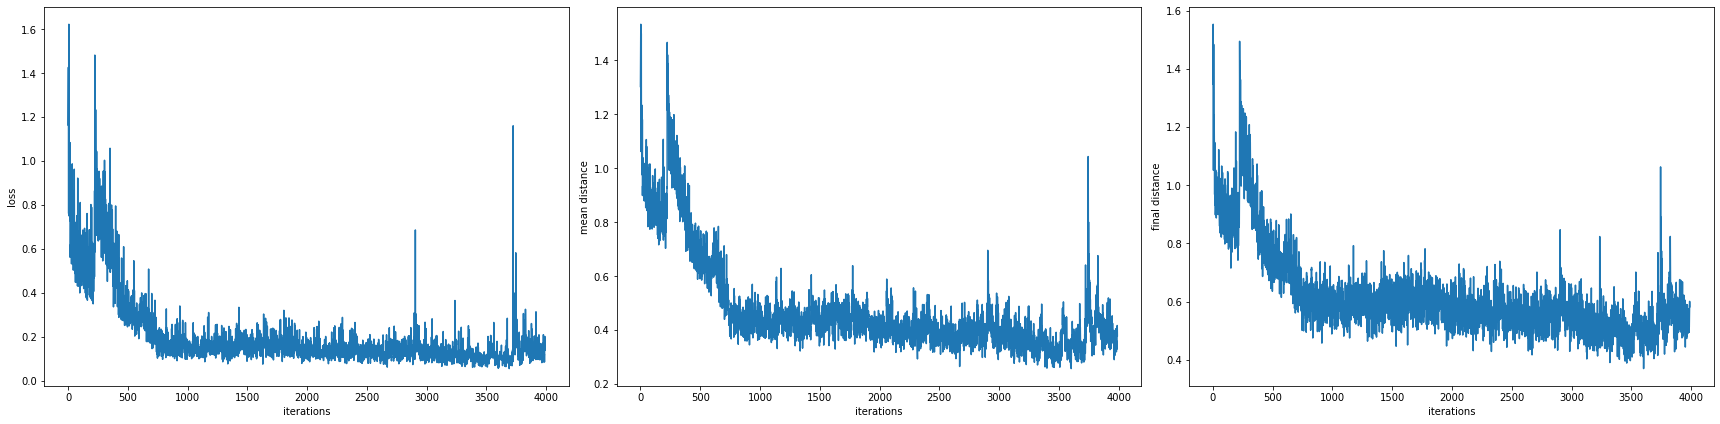

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(24, 6))

ax[0].plot(history['loss'][10::])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('iterations')

ax[1].plot(history['md'][10::])
ax[1].set_ylabel('mean distance')
ax[1].set_xlabel('iterations')

ax[2].plot(history['fd'][10::])
ax[2].set_ylabel('final distance')
ax[2].set_xlabel('iterations')

fig.tight_layout()
fig.savefig('3epoch_incr_training.eps', format='eps')

In [162]:

traj_tf.save_weights("trained_models/3epoch_norm/trained_tf")

In [107]:
!mkdir trained_models/3epoch_norm

In [146]:
reloaded_tf = Transformer()
reloaded_tf.load_weights('trained_models/3epoch_norm/trained_tf')